# Regression Scripts

Script to regress coefficients for relationship between QIDS and various parameters

In [16]:
import os, sys, tqdm
import pprint
import datetime
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib import cm, style
import ipywidgets as widgets

import seaborn as sns
import geopandas as gpd
import pandas as pd

import requests
import json

import folium
import branca
from folium.plugins import TimeSliderChoropleth

import numpy as np
import scipy as sp
import scipy.stats as stats
from scipy import interpolate

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

import utils
import parser
import psychometry

plt.rcParams.update({'font.size': 15})
style.use('seaborn-paper') #sets the size of the charts
style.use('ggplot')

# Some userful references
# https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

In [17]:
if __name__ == '__main__':
    states_geojson_name = 'data/us-states.json'
    states_abbrv_name = 'data/us-state-abbrv.json'
    db_name = 'data/covidsense_db.json'
    
    # Load db and json data
    with open(db_name, 'rb') as f:
        db = json.load(f)

In [18]:
    # Generate epochs for analyzing time series data
    epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
    epoch2 = int(datetime.date.today().strftime('%s'))
    
    start_date = '2020-4-1'
    end_date = datetime.date.today().strftime('%Y-%m-%d')
    
    epochs = pd.date_range(start=start_date, end=end_date, freq='d').astype(int)//10**9
    epochs = np.array(epochs)

In [19]:
    # Find all participants who have responded to QIDS at least twice
    valid_ids = [key for key in db if len(db[key]['QIDS']) > 1]
    db2 = {key:db[key] for key in valid_ids}
    
    nparticipants = len(valid_ids)
    
    columns = ['gender', 'income', 'age', 'education', 'pre_mental', 'pre_physical',
               'marital_status', 'healthcare_worker', 'medications']
    conversion_dict = dict()
    
    # We need to create some conversion dictionaries
    # TODO: Move conversion dictionaries to a separate file
    conversion_dict['gender'] = {'female': 1, 'male': 0, 'other': 0, 'prefer not to answer': 0}
    conversion_dict['income'] = {'$100,000-250,000': 3,
                               '$50,000-100,000': 2,
                               '>$250,000': 4,
                               '$25,000-50,000': 1,
                               '< $25,000': 0,
                               'Yes': 0}
    conversion_dict['education'] = {'more than 16 years of schooling': 3,
                                  '16 years of schooling': 2,
                                  '12-15 years of schooling': 1,
                                  'less than 12 years of schooling': 0}
    conversion_dict['pre_mental'] = {'none of the above': 0,
                                     'depression': 1,
                                     'anxiety disorder': 1,
                                     'other serious mental health issues': 1,
                                     'obsessive compulsive disorder': 1,
                                     'bipolar': 1,
                                     'None': 1,
                                     'addiction (drug, alcohol)': 1,
                                     '0': 0, '>': 0, '$': 0,
                                     '2': 0, '5': 0, ',': 0}
    conversion_dict['pre_physical'] = {'none of the above': 0,
                                     'abnormal blood pressure': 1,
                                     'other serious health issues': 1,
                                     'asthma': 1,
                                     'asthma, COPD or other lung disease': 1,
                                     'diabetes': 1,
                                     'cancer': 1,
                                     '<': 0,' ': 0, '1': 0, '0': 0,
                                     '%': 0}
    
    conversion_dict['marital_status'] = {'married': 1,
                                       'single': 0,
                                       'divorced': 0,
                                       'widowed': 0,
                                       'separated': 0}
    conversion_dict['healthcare_worker'] = {'Yes': 1, 'No': 0}
    conversion_dict['medications'] = {'1 to 4': 1,
                                         'None': 0,
                                         '5 to 10': 2,
                                         'More than 10': 3,
                                         'very worried': 0}
    conversion_dict['age'] = np.arange(np.max(utils.getall(db2, 'age'))+1)
    
    # Create DB for regression
    reg_db = {column:np.zeros(nparticipants) for column in columns}
    delta_qids = np.zeros(nparticipants)
    qids_array = np.zeros(nparticipants)
    
    # Now parse data
    for idx, key in enumerate(valid_ids):
        for column in columns:
            if column == 'pre_physical' or column == 'pre_mental':
                inputs = [conversion_dict[column][val] for val in db2[key][column]]
                if inputs == []:
                    reg_db[column][idx] = 0
                else:
                    if any(inputs) == 1:
                        reg_db[column][idx] = 1
                    else:
                        reg_db[column][idx] = 0
            else:
                try:
                    reg_db[column][idx] = conversion_dict[column][db2[key][column]]
                except KeyError:
                    continue
                
        # Extract delta QIDS too
        timestamps = list(db2[key]['QIDS'].keys())
        qids = list(db2[key]['QIDS'].values())
        
        delta_qids[idx] = qids[-2] - qids[-1]
        qids_array[idx] = qids[-2]
        
    # Append CAMS-R scores. If 'not supplied', set it to 0
    camsr_scores = utils.getall(db2, 'CAMS-R')
    
    for idx, camsr_score in enumerate(camsr_scores):
        if type(camsr_score) is str:
            camsr_scores[idx] = float('nan')
    
    ipip_scores = utils.getall(db2, 'IPIP')
    
    for idx, ipip_score in enumerate(ipip_scores):
        if ipip_score == 'not supplied':
            ipip_scores[idx] = [float('nan') for idx in range(5)]
            
    reg_db['CAMS-R'] = np.array(camsr_scores)
    
    ipip_scores = np.array(ipip_scores)
    
    reg_db['extraversion'] = ipip_scores[:, 0]
    reg_db['agreeableness'] = ipip_scores[:, 1]
    reg_db['conscientiousness'] = ipip_scores[:, 2]
    reg_db['neuroticism'] = ipip_scores[:, 3]
    reg_db['imagination'] = ipip_scores[:, 4]
        
    # Now create a pandas dataframe
    #reg_db['delta_qids'] = delta_qids
    reg_db['qids'] = qids_array
    reg_db['constant'] = np.ones(nparticipants)
    reg_pd = pd.DataFrame.from_dict(reg_db)
    
    reg_pd.head()

,gender,income,age,education,pre_mental,pre_physical,marital_status,healthcare_worker,medications,CAMS-R,extraversion,agreeableness,conscientiousness,neuroticism,imagination,qids,constant
0,0.0,1.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,32.0,2.0,1.25,1.0,2.00,1.00,6.0,1.0
1,0.0,0.0,35.0,3.0,0.0,0.0,0.0,0.0,0.0,24.0,2.0,1.00,1.5,2.00,1.75,10.0,1.0
2,1.0,2.0,43.0,3.0,0.0,1.0,1.0,0.0,1.0,32.0,1.0,0.25,0.5,2.25,0.25,5.0,1.0
3,1.0,3.0,55.0,3.0,0.0,0.0,1.0,0.0,1.0,37.0,3.5,0.50,0.5,2.50,0.50,5.0,1.0
4,0.0,3.0,55.0,3.0,0.0,0.0,1.0,1.0,0.0,34.0,NaN,NaN,NaN,NaN,NaN,0.0,1.0


In [20]:
    # Now we are ready to regress
    
    # We have to assemble our data first
    y = reg_db['qids']
    
    X = np.hstack([reg_db[column].reshape(-1, 1) for column in reg_db if column is not 'qids'])
    varnames = [column for column in reg_db if column is not 'qids']
    
    est = sm.GLS(endog=reg_pd['qids'], exog=reg_pd[varnames], missing='drop')
    est2 = est.fit()
    
    summary = est2.summary(xname=varnames, yname='QIDS')
    print(summary)
    
    summary_csv = summary.as_csv()
    with open('results/ols_regression.csv', 'w') as f:
        f.write(summary_csv)


                            GLS Regression Results                            
Dep. Variable:                   QIDS   R-squared:                       0.414
Model:                            GLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     9.092
Date:                Mon, 10 Aug 2020   Prob (F-statistic):           7.69e-16
Time:                        19:00:29   Log-Likelihood:                -534.60
No. Observations:                 209   AIC:                             1101.
Df Residuals:                     193   BIC:                             1155.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
gender                0.5997      0.57

In [21]:
    def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
        """Return an axes of confidence bands using a simple approach.

        Notes
        -----
        .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
        .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

        References
        ----------
        .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
           http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

        """
        if ax is None:
            ax = plt.gca()

        ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
        ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")

        return ax

    def qids_mood_scatter(epochrange, hw, pm, pp, ml, fm, cv, ms, age):
        epoch1, epoch2 = epochrange
        epoch1 *= 1000
        epoch2 *= 1000
        
        # Now we can do a scatter plot of mood vs. QIDS
        scatter_qids = []
        scatter_mood = []
        scatter_phys = []

        # Create a dictionary to convert mood to numbers
        mood_dict = {'terrible': 0,
                     'poor': 1,
                     'fair': 2,
                     'good': 3,
                     'great': 4,
                     'excellent': 5}

        # Keep filtering for various conditions
        valid_ids = [key for key in db]
        if hw:
            valid_ids = [key for key in valid_ids if db[key]['healthcare_worker'] == 'Yes']
        if pm:
            valid_ids = [key for key in valid_ids if len(db[key]['pre_mental']) > 0]
        if pp:
            valid_ids = [key for key in valid_ids if len(db[key]['pre_physical']) > 0]
        if ms:
            valid_ids = [key for key in valid_ids if db[key]['marital_status'] == 'married']
        if ml:
            valid_ids_ml = [key for key in valid_ids if db[key]['gender'] == 'male']
        else:
            valid_ids_ml = []
            
        if fm:
            valid_ids_fm = [key for key in valid_ids if db[key]['gender'] == 'female']
        else:
            valid_ids_fm = []
        
        valid_ids = valid_ids_ml + valid_ids_fm
        
        if cv:
            valid_ids = [key for key in valid_ids if len(db[key]['I']) > 0]
            
        # Age filter
        valid_ids = [key for key in valid_ids if db[key]['age'] > age[0]]
        valid_ids = [key for key in valid_ids if db[key]['age'] < age[1]]
            
        db_filtered = {key:db[key] for key in valid_ids}

        for key, val in db_filtered.items():
            
            qids_array = val['QIDS']
            qids_timestamps = np.array([int(timestamp) for timestamp in list(qids_array.keys())])
            qids_values = np.array(list(qids_array.values()))

            # Not optimized currently, but just go through each value and find out
            # the first qids value in given time zone
            success = False
            for idx, timestamp in enumerate(qids_timestamps):

                if timestamp > epoch1 and timestamp < epoch2:
                    qids_value = qids_values[idx]
                    success = True
                    break

            # Next, mood array

            mood_array = [item['mood'] for item in val['A']]
            mood_timestamps = [item['time'] for item in val['A']]
            
            phys_array = [item['symptoms'] for item in val['A']]

            mood_avg = 0
            nmood = 0
            
            symptoms_avg = 0
            nsymptoms = 0

            for idx, timestamp in enumerate(mood_timestamps):
                if timestamp > epoch1 and timestamp < epoch2:
                    mood_avg += mood_dict[mood_array[idx]]
                    nmood += 1.0
                    
                    symptoms_avg += len(phys_array[idx])
                    nsymptoms += 1.0

            if nmood == 0:
                continue
                
            if symptoms_avg < 2:
                continue 
                
            if nsymptoms == 0:
                continue
                
            if success is False:
                continue

            mood_avg /= nmood
            symptoms_avg /= nsymptoms

            scatter_qids.append(qids_value + np.random.randn(1)*0.1)
            scatter_mood.append(mood_avg + np.random.randn(1)*0.1)
            scatter_phys.append(symptoms_avg + np.random.randn(1)*0.1)
            #scatter_qids.append(qids_value)
            #scatter_mood.append(mood_avg)
            #scatter_phys.append(symptoms_avg)
            
        scatter_qids = np.array(scatter_qids).ravel()
        scatter_mood = np.array(scatter_mood).ravel()
        scatter_phys = np.array(scatter_phys).ravel()
            
        # For now, regress with just one single line
        p, cov = np.polyfit(scatter_qids, scatter_mood, 1, cov=True)
        dof = scatter_qids.size - p.size
        
        scatter_mood_fit = np.polyval(p, scatter_qids)
        
        # Compute confidence intervals
        tval = stats.t.ppf(0.975, dof)
        res = scatter_mood - scatter_mood_fit
        chi2 = np.sum((res / scatter_mood_fit)**2)
        chi2_red = chi2 / dof
        
        s_err = np.sqrt(np.sum(res**2) / dof) 
        
        indices1 = scatter_qids < 6
        indices2 = (scatter_qids > 6) * (scatter_qids < 11)
        indices3 = (scatter_qids > 11) * (scatter_qids < 16)
        indices4 = scatter_qids > 16
        
        # Now scatter
        fig = plt.figure(dpi=100)
        sns.regplot(scatter_qids[indices1], scatter_mood[indices1])
        sns.regplot(scatter_qids[indices2], scatter_mood[indices2])
        sns.regplot(scatter_qids[indices3], scatter_mood[indices3])
        sns.regplot(scatter_qids[indices4], scatter_mood[indices4])
        
        plt.xlabel('QIDS')
        plt.ylabel('Mood')

        plt.xlim([0, 27])
        plt.ylim([0, 6])
        plt.yticks(list(mood_dict.values()), labels=list(mood_dict.keys()))

        # Add vertical lines differentiating into various zones
        plt.axvline(x=6.0, linestyle='--', color='gray', linewidth=0.8)
        plt.annotate('Mild depression', xy=(6.5, 4))

        plt.axvline(x=11.0, linestyle='--', color='gray', linewidth=0.9)
        plt.annotate('Moderate depression', xy=(11.5, 3))

        plt.axvline(x=16.0, linestyle='--', color='gray', linewidth=1.0)
        plt.annotate('Severe depression', xy=(16.5, 2))

        plt.title('%s - %s'%(d2s(epoch1), d2s(epoch2)))
        
        fig = plt.figure(dpi=100)
        sns.regplot(scatter_phys, scatter_mood)
        plt.xlabel('Intensity of physical symptoms')
        plt.ylabel('Mood')
        plt.yticks(list(mood_dict.values()), labels=list(mood_dict.keys()))
        plt.title('%s - %s'%(d2s(epoch1), d2s(epoch2)))
        
        plt.show()
        
    # Time gate to two (?) weeks
    epoch1 = datetime.datetime(2020, 5, 1, 0, 0).timestamp()*1000
    epoch2 = datetime.datetime(2020, 5, 7, 0, 0).timestamp()*1000
    
    start_date = datetime.datetime(2020, 4, 1)
    end_date = datetime.date.today()

    dates = pd.date_range(start_date, end_date, freq='D')

    options = [(date.strftime(' %d %b '), date.timestamp()) for date in dates]
    index = (0, len(options)-1)

    selection_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description='Dates',
        orientation='horizontal',
        layout={'width': '500px'}
    )
    
    hw_checkbox = widgets.Checkbox(
        value=False,
        description='Healthcare worker',
        disabled=False
    )
    
    pm_checkbox = widgets.Checkbox(
        value=False,
        description='Pre existing mental condition',
        disabled=False
    )
    
    pp_checkbox = widgets.Checkbox(
        value=False,
        description='Pre existing physical condition',
        disabled=False
    )
    
    ml_checkbox = widgets.Checkbox(
        value=True,
        description='Male',
        disable=False
    )
    
    fm_checkbox = widgets.Checkbox(
        value=True,
        description='Female',
        disable=False
    )
    
    cv_checkbox = widgets.Checkbox(
        value=False,
        description='COVID19 patient',
        disable=False
    )
    
    ms_checkbox = widgets.Checkbox(
        value=False,
        description='Married only',
        disable=False
    )
    
    age_slider = widgets.IntRangeSlider(
        value=[18, 100],
        min=18,
        max=100,
        step=1,
        description='Age',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    
    
    
    widgets.interact(
        qids_mood_scatter,
        epochrange=selection_range_slider,
        hw=hw_checkbox,
        pm=pm_checkbox,
        pp=pp_checkbox,
        ml=ml_checkbox,
        fm=fm_checkbox,
        cv=cv_checkbox,
        ms=ms_checkbox,
        age=age_slider
    )


interactive(children=(SelectionRangeSlider(description='Dates', index=(0, 131), layout=Layout(width='500px'), …

<function __main__.qids_mood_scatter(epochrange, hw, pm, pp, ml, fm, cv, ms, age)>

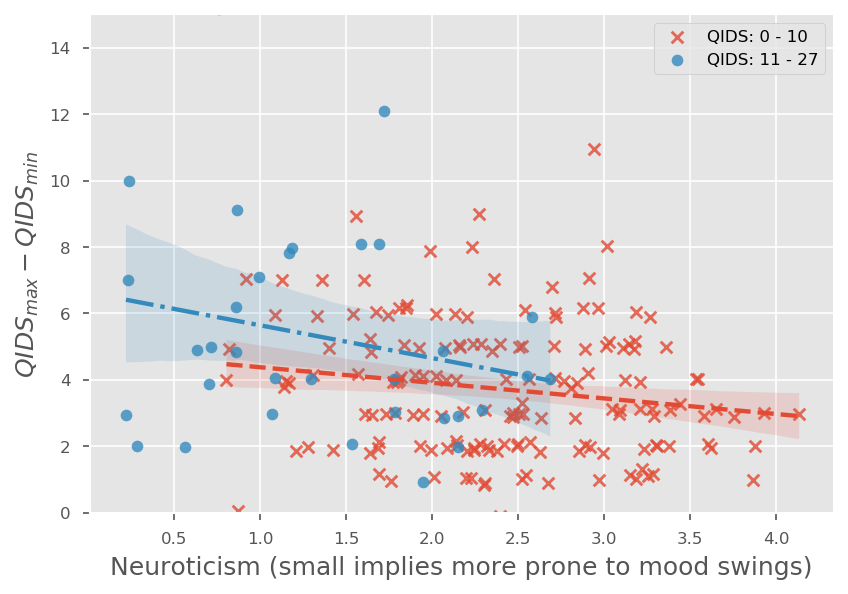

In [22]:
    # QIDS swing
    min_nqids = 2
    min_qids_array = [0, 11]
    max_qids_array = [10, 27]
    
    fig = plt.figure(dpi=150)
    #labels = ['No depression', 'Mild', 'Moderate', 'Severe', 'Very severe']
    labels = ['QIDS: 0 - 10', 'QIDS: 11 - 27']
    markers = ['x', 'o', 'p', 's', '*']
    linestyles = ['--', '-.', ':', '-']
    
    for idx, min_qids in enumerate(min_qids_array):
        max_qids = max_qids_array[idx]
        
        scatter_qids = []
        scatter_camsr = []
        scatter_ipip = []
        
        for key, val in db.items():
            qids_array = list(val['QIDS'].values())

            if len(qids_array) < min_nqids:
                continue

            mean_qids = np.mean(qids_array)
            
            if len(val['pre_mental']) == 0:
                continue

            if (mean_qids < min_qids) or (mean_qids > max_qids):
                continue

            if 'CAMS-R' not in val:
                continue

            if 'IPIP' not in val:
                continue

            scatter_qids.append(max(qids_array) - min(qids_array) + np.random.randn(1)*0.1)
            scatter_camsr.append(val['CAMS-R'] + np.random.randn(1)*0.1)
            scatter_ipip.append(val['IPIP'][3] + np.random.randn(1)*0.1)

        # Now plot
        if len(scatter_qids) < 2:
            continue
        handle = sns.regplot(scatter_ipip, scatter_qids, label=labels[idx],
                             marker=markers[idx], line_kws={'linestyle':linestyles[idx]})
        
    #plt.xlabel('CAMS-R (mindfulness)')
    plt.xlabel('Neuroticism (small implies more prone to mood swings)')
    plt.ylabel('$QIDS_{max} - QIDS_{min}$')
    plt.ylim([0, 15])
    plt.legend()
    plt.show()

/home/vs44/miniconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/home/vs44/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/vs44/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


QIDS vs. mood
	Mann-Whitney U: stat: 2416.00; pval: 0.049489
	t-test: stat: 1.20; pval: 0.2359
QIDS degradation with time
	Mann-Whitney U: stat: 903.00; pval: 0.637021
	t-test: stat: -1.57; pval: 0.1199


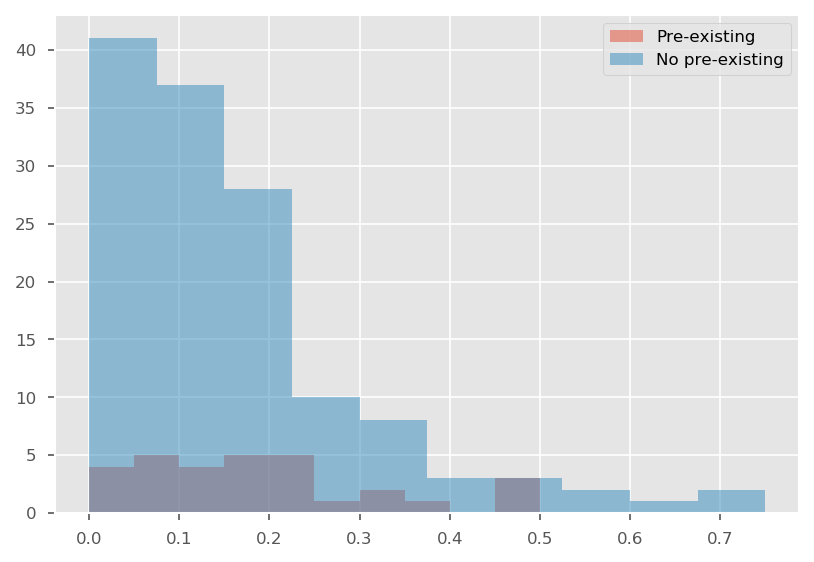

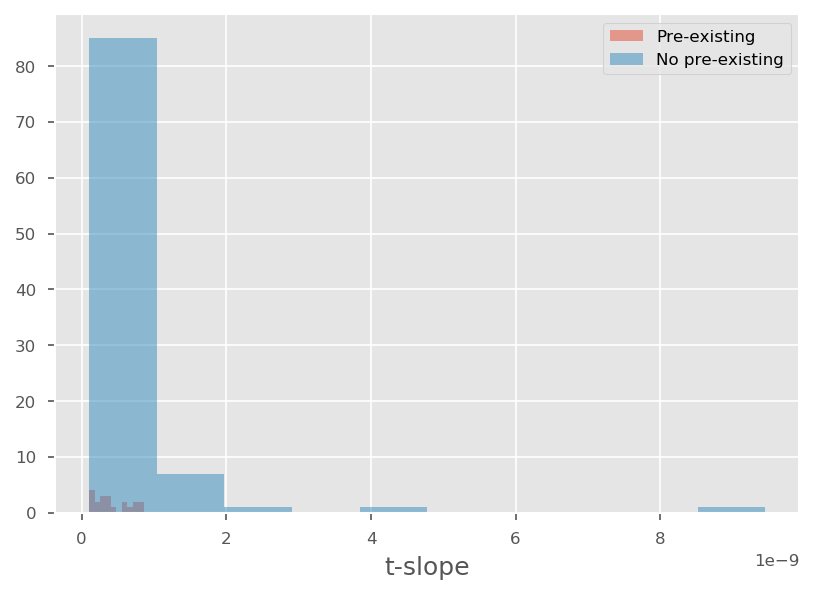

In [23]:
    # Compare correlation between mood and QIDS for two different categories
    mood_dict = {'terrible': 5,
                     'poor': 4,
                     'fair': 3,
                     'good': 2,
                     'great': 1,
                     'excellent': 0}
    
    #db_h = {key:db[key] for key in db if db[key]['gender'] == 'male'}
    db_h = {key:db[key] for key in db}
    db_pre = {key: db_h[key] for key in db_h if len(db_h[key]['pre_mental']) > 1 and len(db_h[key]['QIDS']) > 2}
    db_nopre = {key: db_h[key] for key in db_h if len(db_h[key]['pre_mental']) > 0 and len(db_h[key]['QIDS']) > 2}
    
    corr_pre = np.zeros(len(db_pre))
    corr_nopre = np.zeros(len(db_nopre))
    
    tcorr_pre = np.zeros(len(db_pre))
    tcorr_nopre = np.zeros(len(db_nopre))
    
    for idx, key in enumerate(db_pre):
        qids_array = db_pre[key]['QIDS']
        A_array = db_pre[key]['A']
        
        mood_vals = np.array([mood_dict[A['mood']] for A in A_array])
        mood_times = np.array([A['time'] for A in A_array])
        
        qids_vals = np.array(list(qids_array.values()))
        qids_times = np.array(list(qids_array.keys())).astype(int)
        
        indices = np.argsort(qids_times)
        qids_vals = qids_vals[indices]
        qids_times = qids_times[indices]
        mood_projected_vals = np.zeros_like(qids_vals)
        
        # Perform time series regression
        p, res = np.polyfit(qids_times, qids_vals, 1, cov=True)
        tcorr_pre[idx] = p[0]
        
        for idx2, timestamp in enumerate(qids_times):
            epoch1 = int(timestamp)
            epoch2 = epoch1 - 7*24*3600*1000
            
            mood_avg = 0
            nmood = 0
            
            for idx3, mood_timestamp in enumerate(mood_times):
                if mood_timestamp >= epoch2 and mood_timestamp <= epoch1:
                    mood_avg += mood_vals[idx3]
                    nmood += 1
                    
            mood_avg /= max(1, nmood)
            mood_projected_vals[idx2] = mood_avg
            
        # Ensure we have values only when both mood and qids are available
        qids_vals = qids_vals[mood_projected_vals != 0]
        mood_projected_vals = mood_projected_vals[mood_projected_vals != 0]
        
        if len(qids_vals) > 2:
            # Now we are ready to regress
            p, res = np.polyfit(qids_vals, mood_projected_vals, 1, cov=True)
            corr_pre[idx] = p[0]
            
    for idx, key in enumerate(db_nopre):
        qids_array = db_nopre[key]['QIDS']
        A_array = db_nopre[key]['A']
        
        mood_vals = np.array([mood_dict[A['mood']] for A in A_array])
        mood_times = np.array([A['time'] for A in A_array])
        
        qids_vals = np.array(list(qids_array.values()))
        qids_times = np.array(list(qids_array.keys())).astype(int)
        
        indices = np.argsort(qids_times)
        qids_vals = qids_vals[indices]
        qids_times = qids_times[indices]
        mood_projected_vals = np.zeros_like(qids_vals)
        
        # Perform time series regression
        p, res = np.polyfit(qids_times, qids_vals, 1, cov=True)
        tcorr_nopre[idx] = p[0]
        
        for idx2, timestamp in enumerate(qids_times):
            epoch1 = int(timestamp)
            epoch2 = epoch1 - 7*24*3600*1000
            
            mood_avg = 0
            nmood = 0
            
            for idx3, mood_timestamp in enumerate(mood_times):
                if mood_timestamp >= epoch2 and mood_timestamp <= epoch1:
                    mood_avg += mood_vals[idx3]
                    nmood += 1
                    
            mood_avg /= max(1, nmood)
            mood_projected_vals[idx2] = mood_avg
            
        # Ensure we have values only when both mood and qids are available
        qids_vals = qids_vals[mood_projected_vals != 0]
        mood_projected_vals = mood_projected_vals[mood_projected_vals != 0]
        
        if len(qids_vals) > 3:
            # Now we are ready to regress
            try:
                p, res = np.polyfit(qids_vals, mood_projected_vals, 1, cov=True)
                corr_nopre[idx] = p[0]
            except np.linalg.LinAlgError:
                continue
                
    # Sanitize data a bit
    corr_pre = corr_pre[corr_pre > 1e-20]
    corr_pre = corr_pre[corr_pre < 1.5]
    
    corr_nopre = corr_nopre[corr_nopre > 1e-20]
    
    tcorr_pre = tcorr_pre[tcorr_pre > 1e-10]
    tcorr_nopre = tcorr_nopre[tcorr_nopre > 1e-10]
    
    # Now time to do stats
    mw_stat, mw_pval = stats.mannwhitneyu(corr_pre, corr_nopre, alternative='greater')
    tt_stat, tt_pval = stats.ttest_ind(corr_pre, corr_nopre, equal_var=False)
    
    print('QIDS vs. mood')
    print('\tMann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('\tt-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    # Now time to do stats
    mw_stat, mw_pval = stats.mannwhitneyu(tcorr_pre, tcorr_nopre, alternative='greater')
    tt_stat, tt_pval = stats.ttest_ind(tcorr_pre, tcorr_nopre, equal_var=False)
    
    print('QIDS degradation with time')
    print('\tMann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('\tt-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    fig = plt.figure(dpi=150)
    plt.hist(corr_pre, label='Pre-existing', alpha=0.5)
    plt.hist(corr_nopre, label='No pre-existing', alpha=0.5)
    plt.legend()
    
    fig = plt.figure(dpi=150)
    plt.hist(tcorr_pre, label='Pre-existing', alpha=0.5)
    plt.hist(tcorr_nopre, label='No pre-existing', alpha=0.5)
    plt.xlabel('t-slope')
    plt.legend()
    
    plt.show()
            
    

QIDS swing:
	Mann-Whitney U: stat: 13458.50; pval: 0.032744
	t-test: stat: 1.72; pval: 0.0872
Mood swing:
	Mann-Whitney U: stat: 12829.50; pval: 0.127209
	t-test: stat: 1.23; pval: 0.2211


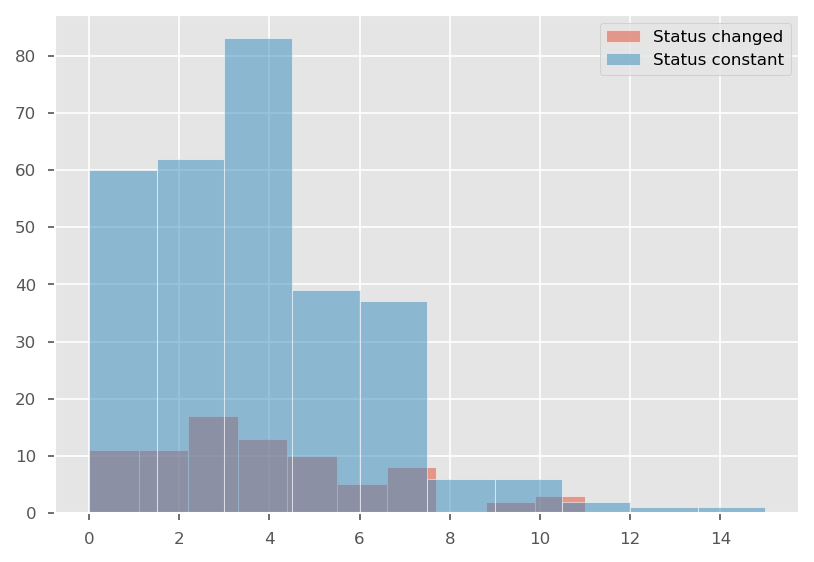

In [24]:
    # Status statistics (quarantine, lockdown, etc.)
    statuses = []
    
    status_dict = {'Sheltered-in-place': 0,
                 'Mandatory work from home': 0,
                 'Self-quarantined': 0,
                 'Voluntarily work from home': 0,
                 'On lockdown': 0,
                 'Going to work as usual': 1,
                 'None of the above': 0,
                 'Going to work with reduced hours': 1}
    
    # As a first test, let us estimate QIDS swing
    qids_swing_no_status_change = []
    qids_swing_status_change = []
    
    mood_swing_no_status_change = []
    mood_swing_status_change = []
    
    for key in db:
        qids_array = list(db[key]['QIDS'].values())
        if len(qids_array)  < 2:
            continue
            
        A_array = db[key]['A']
        try:
            status_array = [status_dict[status] for A in A_array for status in A['situation']]
        except KeyError:
            continue
        
        mood_array = [mood_dict[A['mood']] for A in A_array]
        if len(mood_array) < 2:
            continue
        
        if len(np.unique(status_array)) > 1:
            statuses.append(status_array)
            qids_swing_status_change.append(max(qids_array) - min(qids_array))
            mood_swing_status_change.append(max(mood_array) - min(mood_array))
        else:
            qids_swing_no_status_change.append(max(qids_array) - min(qids_array))
            mood_swing_no_status_change.append(max(mood_array) - min(mood_array))
            
    # Now time to do stats
    mw_stat, mw_pval = stats.mannwhitneyu(qids_swing_status_change, qids_swing_no_status_change, alternative='greater')
    tt_stat, tt_pval = stats.ttest_ind(qids_swing_status_change, qids_swing_no_status_change, equal_var=False)
    
    print('QIDS swing:')
    print('\tMann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('\tt-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
    
    mw_stat, mw_pval = stats.mannwhitneyu(mood_swing_status_change, mood_swing_no_status_change, alternative='greater')
    tt_stat, tt_pval = stats.ttest_ind(mood_swing_status_change, mood_swing_no_status_change, equal_var=False)
    
    print('Mood swing:')
    print('\tMann-Whitney U: stat: %.2f; pval: %.6f'%(mw_stat, mw_pval))
    print('\tt-test: stat: %.2f; pval: %.4f'%(tt_stat, tt_pval))
        
    fig = plt.figure(dpi=150)
    plt.hist(qids_swing_status_change, alpha=0.5, ec='white', label='Status changed')
    plt.hist(qids_swing_no_status_change, alpha=0.5, ec='white', label='Status constant')
    plt.legend()
    plt.show()
        